In [1]:
import numpy as np
import torch
from torch import nn
from torch import functional as F
import math

In [2]:
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [3]:
from livelossplot import PlotLosses

In [4]:
sigma_noise = 0.1
(x_data, y_data) = torch.load('foong_data.pt')

In [5]:
def log_norm(x, mu, std):
    """Compute the log pdf of x,
    under a normal distribution with mean mu and standard deviation std."""
    return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)

In [6]:
def rho_to_sigma(rho):
    sigma = torch.log(1 + torch.exp(rho))
    return sigma

In [7]:
def sigma_to_rho(sigma):
    rho = torch.log(torch.exp(sigma) - 1)
    return rho

In [8]:
class ProbabilisticLinear(nn.Module):
    __constants__ = ['bias', 'in_features', 'out_features']

    def __init__(self, in_features, out_features, bias=True):
        super(ProbabilisticLinear, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        
        self.q_weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.q_weight_rho = nn.Parameter(torch.Tensor(out_features, in_features))
        self.q_bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.q_bias_rho = nn.Parameter(torch.Tensor(out_features))
        
        self.weight_epsilon = torch.Tensor(out_features, in_features)
        self.bias_epsilon = torch.Tensor(out_features, in_features)
        
        self.weight_sample = torch.Tensor(out_features, in_features)
        self.bias_sample = torch.Tensor(out_features, in_features)
        
        self.reset_parameters()
        
        mu = torch.tensor(0.0)
        rho = sigma_to_rho(torch.tensor(1.0))
        
        self.prior_weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.prior_weight_rho = nn.Parameter(torch.Tensor(out_features, in_features))
        self.prior_bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.prior_bias_rho = nn.Parameter(torch.Tensor(out_features))
        
        self.prior_weight_mu.requires_grad = False
        self.prior_weight_rho.requires_grad = False
        self.prior_bias_mu.requires_grad = False
        self.prior_bias_rho.requires_grad = False
        
        nn.init.constant_(self.prior_weight_mu, mu)
        nn.init.constant_(self.prior_weight_rho, rho)
        nn.init.constant_(self.prior_bias_mu, mu)
        nn.init.constant_(self.prior_bias_rho, rho)
        
    def generate_rand(self):
        self.weight_epsilon = torch.randn(size=self.q_weight_mu.size())
        self.bias_epsilon = torch.randn(size=self.q_bias_mu.size())
        return (self.weight_epsilon, self.bias_epsilon)
    
    def reparameterization(self):
        sigma_weight = rho_to_sigma(self.q_weight_rho)
        self.weight_sample = self.weight_epsilon.mul(sigma_weight).add(self.q_weight_mu)
        
        sigma_bias = rho_to_sigma(self.q_bias_rho)
        self.bias_sample = self.bias_epsilon.mul(sigma_bias).add(self.q_bias_mu)
        return (self.weight_sample, self.bias_sample)

    def q_log_pdf(self):
        sigma_weight = rho_to_sigma(self.q_weight_rho)
        nw = torch.distributions.Normal(self.q_weight_mu, sigma_weight)
        
        sigma_bias = rho_to_sigma(self.q_bias_rho)
        nb = torch.distributions.Normal(self.q_bias_mu, sigma_bias)
        
        return nw.log_prob(self.weight_sample).sum() + nb.log_prob(self.bias_sample).sum()
    
    def prior_log_pdf(self):
        sigma_weight = rho_to_sigma(self.prior_weight_rho)
        nw = torch.distributions.Normal(self.prior_weight_mu, sigma_weight)
        
        sigma_bias = rho_to_sigma(self.prior_bias_rho)
        nb = torch.distributions.Normal(self.prior_bias_mu, sigma_bias)
        
        return nw.log_prob(self.weight_sample).sum() + nb.log_prob(self.bias_sample).sum()
    
    def lock_means(self):
        self.q_weight_mu.requires_grad = False
        self.q_bias_mu.requires_grad = False
        
    def lock_rhos(self):
        self.q_weight_rho.requires_grad = False
        self.q_bias_rho.requires_grad = False
        
    def unlock_means(self):
        self.q_weight_mu.requires_grad = True
        self.q_bias_mu.requires_grad = True
        
    def unlock_rhos(self):
        self.q_weight_rho.requires_grad = True
        self.q_bias_rho.requires_grad = True
        
    def set_parameters(self, w_sample, b_sample):
        self.weight_sample = w_sample
        self.bias_sample = b_sample
    
    def reset_parameters(self):
        torch.nn.init.normal_(self.q_weight_mu, mean=0.0, std=3.0)
        torch.nn.init.constant_(self.q_weight_rho, -5.0)
        torch.nn.init.normal_(self.q_bias_mu, mean=0.0, std=3.0)
        torch.nn.init.constant_(self.q_bias_rho, -5.0)
       
    def forward(self, input):
        return torch.nn.functional.linear(input, self.weight_sample, bias=self.bias_sample)

In [9]:
class RegressionModel(nn.Module):
    def __init__(self, H):
        super(RegressionModel, self).__init__()
        
        self.linear1 = ProbabilisticLinear(1, H)
        self.linear2 = ProbabilisticLinear(H,1)
        
        self.registered_layers = []
        self.registered_layers.append(self.linear1)
        self.registered_layers.append(self.linear2)
        
        self.nb_parameters = self.count_parameters()
        
    def forward(self, x):
        out = x;
        for k in range(len(self.registered_layers)-1):
            out = torch.tanh(self.registered_layers[k](out))
        out = self.registered_layers[-1](out)
        return out
    
    def resample_parameters(self):
        w_samples = []
        b_samples = []
        for k in range(len(self.registered_layers)):
            self.registered_layers[k].generate_rand()
            self.registered_layers[k].reparameterization()
        
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def lock_means(self):
        for k in range(len(self.registered_layers)):
            self.registered_layers[k].lock_means()
        
    def lock_rhos(self):
        for k in range(len(self.registered_layers)):
            self.registered_layers[k].lock_rhos()
        
    def unlock_means(self):
        for k in range(len(self.registered_layers)):
            self.registered_layers[k].unlock_means()
        
    def unlock_rhos(self):
        for k in range(len(self.registered_layers)):
            self.registered_layers[k].unlock_rhos()
            
    def set_parameters(self, w_samples, b_samples):
        for k in range(len(self.registered_layers)):
            self.registered_layers[k].set_parameters(w_samples[k], b_samples[k])
    
    def q_log_pdf(self):
        list_LQ = []
        for k in range(len(self.registered_layers)):
            list_LQ.append(self.registered_layers[k].q_log_pdf())
        stack_LQ = torch.stack(list_LQ)
        return torch.sum(stack_LQ)
    
    def p_log_pdf(self):
        list_LP = []
        for k in range(len(self.registered_layers)):
            list_LP.append(self.registered_layers[k].p_log_pdf())
        stack_LP = torch.stack(list_LP)
        return torch.sum(stack_LP)
        
    def compute_elbo(self, x_data, y_data, sample_size):
        L = []
        for _ in range(sample_size):
            self.resample_parameters()

            LQ = self.q_log_pdf() 
            LP = self.p_log_pdf() 

            y_pred = self.forward(x_data)
            LL = log_norm(y_data, y_pred.t(), torch.tensor(sigma_noise)).sum()

            L.append(LQ - LP - LL)
        L = torch.stack(L)
        L = torch.mean(L)
        return L

In [59]:
class BoostingModel(nn.Module):
    
    def __init__(self, H, nComponents):
        super(BoostingModel, self).__init__()
        
        self.components = [RegressionModel(H)]
        self.mixture_probas = torch.tensor(1.)
        self.current_nComponents = 1
        self.current_component = self.components[0]
        self.current_component_index = 0
        self.current_parameters = {'weight': [layer[k].weight_sample for layer in self.current_component.registered_layers],
                                   'bias': [layer[k].bias_sample for layer in self.current_component.registered_layers]}
    
    def refresh_current_parameters(self):
        self.current_parameters = {'weight': [layer[k].weight_sample for layer in self.current_component.registered_layers],
                                   'bias': [layer[k].bias_sample for layer in self.current_component.registered_layers]}
    
    def forward(self, x):
        unweighted_out = [component(x) for component in self.components]
        out = [unweightd_out[i]*self.mixture_probas[i] for i in range(self.current_nComponents)]
        return out
    
    def resample_parameters_in_eval(self):
        self.current_component = np.random.choice(self.components, self.mixture_probas)
        self.current_component.resample_parameters()
        self.set_current_parameters()
        
    def resample_parameters_in_train(self):
        self.current_component = np.random.choice(self.components[:-1], self.mixture_probas[:-1])
        self.current_component.resample_parameters()
        self.refresh_current_parameters()
        
    def mixture_log_pdf(self):
        probs = torch.stack((self.mixture_probas[:-1]*(1-self.mixture_probas[-1]), self.mixture_probas[-1]))
        log_q = []
        for i, component in enumerate(self.components):
            component.set_parameters(self.current_parameters['weight'], self.current_parameters['bias'])
            log_q.append(probs[i]*torch.exp(component.q_log_pdf()))
        log_q = torch.log(torch.sum(log_q))
        return(log_q)
    
    def compute_mixture_elbo(self, x_data, y_data, sample_size):
        
        L = []
        
        for comp in self.components:
            L.append(comp.compute_elbo(x_data, y_data, sample_size))
        L = torch.mul(self.mixture_probas, L)
        return L
    
    def new_component(self, losses, epsilon, new_pi):
        
        if torch.std(losses) < epsilon and len(self.components)<nComponents:
            self.components[-1].lock_means()
            self.components[-1].lock_rhos()
            self.mixture_probas[-1].requires_grad = False
            
            self.components.append(RegressionModel(H))
            self.mixture_probas.detach()
            pi = torch.tensor(float(new_pi), requires_grad = True)
            pi = torch.nn.Sigmoid(pi)
            self.mixture_probas = torch.stack((self.mixture_probas, pi))
            return 1

        elif torch.std(losses) < epsilon and len(self.components)>=nComponents:
            
            return 0
        else:
            return 1
            
        
        

In [10]:
model = RegressionModel(50)

In [60]:
bmodel = BoostingModel(50, 3)

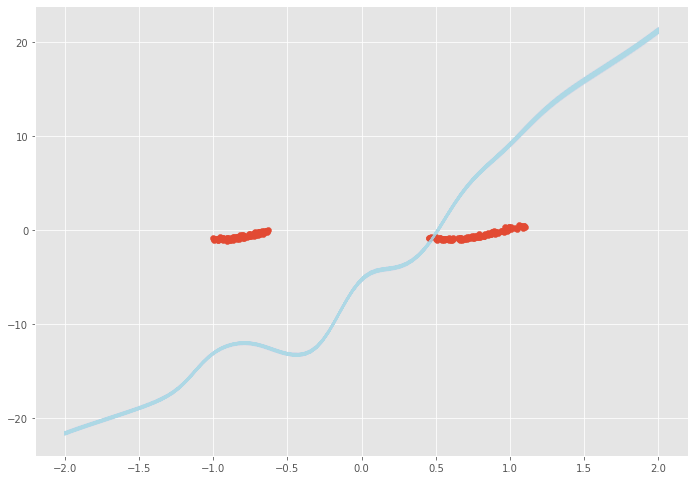

In [11]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    model.resample_parameters()

    y_test = model.forward(x_test)
    plt.plot(x_test.detach().cpu().numpy(), y_test.detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [139]:
import torch
from torch import nn
from torchviz import make_dot, make_dot_from_trace
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/cortax/Anaconda3/Library/bin/graphviz/'

In [140]:
#make_dot(model(x_data), params=dict(model.named_parameters()))

In [12]:
learning_rate = 0.05
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.95,verbose=True)
optimizer.zero_grad()

In [14]:
int(.005/learning_rate)+1

1

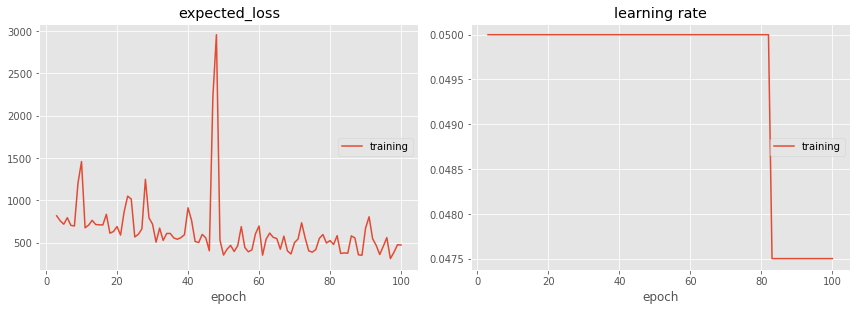

expected_loss:
training   (min:  309.864, max: 2956.545, cur:  470.737)

learning rate:
training   (min:    0.048, max:    0.050, cur:    0.048)


In [16]:
%matplotlib inline
num_epoch = 100
num_iterations = 100
liveloss = PlotLosses()

M = int(.005/learning_rate)+1
for j in range(num_epoch):
    logs = {}
    losses = [None] * num_iterations
    
    for k in range(num_iterations):
        optimizer.zero_grad()
        loss = model.compute_elbo(x_data, y_data, M)
        losses[k] = loss
        loss.backward()
        optimizer.step()
    
    logs['expected_loss'] = torch.stack(losses).mean().detach().clone().numpy()
    logs['learning rate'] = optimizer.param_groups[0]['lr']
    lr = optimizer.param_groups[0]['lr']
    M = int(.005/lr)+1
    print(M)
    liveloss.update(logs)
    liveloss.draw()
    
    scheduler.step(logs['expected_loss'])
    

In [18]:
model.requires_grad_(False)

RegressionModel(
  (linear1): ProbabilisticLinear()
  (linear2): ProbabilisticLinear()
)

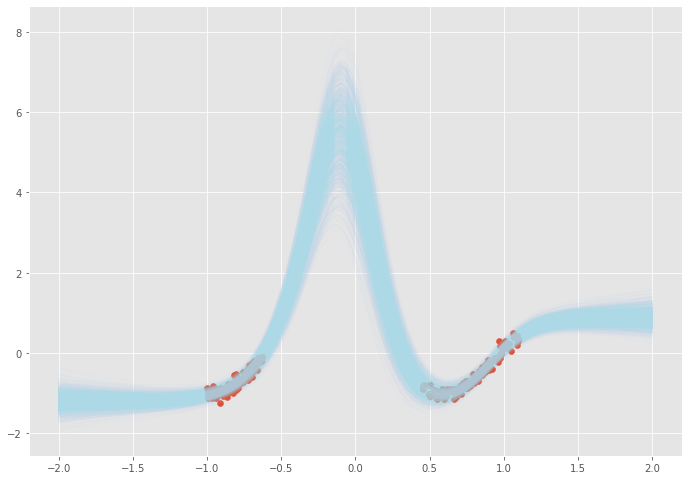

In [158]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    (L1_weight_epsilon, L1_bias_epsilon) = model.linear1.generate_rand()
    (L1_weight_sample, L1_bias_sample) = model.linear1.reparameterization()
    
    y_test = model.forward(x_test)
    plt.plot(x_test.detach().cpu().numpy(), y_test.detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')